# ARDL model

Train set size: 334
Test  set size: 38
 - best_lag by PACF: 1, best_lag by AIC: 1
Selected best lag (TRAIN only) for ARDL in levels: 1

=== ARDL (levels) Model Summary ===
                              ARDL Model Results                              
Dep. Variable:              log_pcepi   No. Observations:                  334
Model:                       ARDL(1,)   Log Likelihood                1621.199
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Mon, 10 Mar 2025   AIC                          -3234.398
Time:                        16:03:57   BIC                          -3219.165
Sample:                    02-01-1990   HQIC                         -3228.324
                         - 10-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0515      0.031

/Users/ayesharahman1/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ayesharahman1/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)



=== Evaluation on Test Set ===
RAW Forecast  =>  MAE = 0.3010,  RMSE = 0.4066
Smoothed      =>  MAE = 0.3156,  RMSE = 0.4019


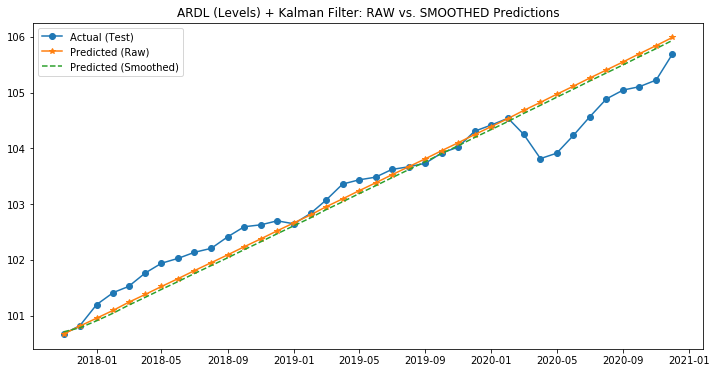

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.stattools import pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from pykalman import KalmanFilter

# Loading the data
file_path = "../Data/train/trains1990s.csv"
df = pd.read_csv(file_path)

# Convert to datetime and set as index
df["observation_date"] = pd.to_datetime(df["observation_date"])
df.set_index("observation_date", inplace=True)

# Ensure target variable exists
if "fred_PCEPI" not in df.columns:
    raise ValueError("Column 'fred_PCEPI' not found in dataset")

# Keep only the target, drop rows where it's missing
df = df[["fred_PCEPI"]].dropna()

# (A) LOG-TRANSFORM (assuming PCEPI > 0)
df["log_pcepi"] = np.log(df["fred_PCEPI"])

# Train/Tets split
train_size = int(0.90 * len(df))
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"Train set size: {len(train_df)}")
print(f"Test  set size: {len(test_df)}")

# Select lags on the log-level series (no differnecing)
def best_lag_selection(train_series, max_lags=12):
    """
    Picks a 'best_lag' for ARDL in levels by:
      1) Checking partial autocorrelation (PACF)
      2) Checking a simple AR(lag) model's AIC
    Returns an integer 'best_lag'.
    """
    pacf_vals = pacf(train_series, nlags=max_lags)
    best_pacf_lag = np.argmax(np.abs(pacf_vals[1:])) + 1

    best_aic_lag, best_aic = 1, float("inf")
    for lag in range(1, max_lags + 1):
        y = train_series[lag:]
        X = train_series.shift(lag)[lag:]
        X = sm.add_constant(X, prepend=True)
        try:
            model = sm.OLS(y, X).fit()
            if model.aic < best_aic:
                best_aic_lag = lag
                best_aic = model.aic
        except:
            continue

    selected_lag = min(best_pacf_lag, best_aic_lag)
    print(f" - best_lag by PACF: {best_pacf_lag}, best_lag by AIC: {best_aic_lag}")
    return selected_lag

best_lag = best_lag_selection(train_df["log_pcepi"], max_lags=12)
print(f"Selected best lag (TRAIN only) for ARDL in levels: {best_lag}")

# ARDL model with a linear trend since no exogenous variables
final_model = ARDL(endog=train_df["log_pcepi"], lags=best_lag, trend='ct').fit()
print("\n=== ARDL (levels) Model Summary ===")
print(final_model.summary())

# Forecast in log-levels
start_idx = test_df.index[0]
end_idx   = test_df.index[-1]

pred_log_test = final_model.predict(start=start_idx, end=end_idx)
pred_log_test = pd.Series(pred_log_test, index=test_df.index)

# Exponentiate to get back to original scale (raw predictions)
predictions_raw = np.exp(pred_log_test)  # "raw" ARDL forecast in original PCEPI scale

# Kalman Filter on the test forecast 
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)

predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), 
                                 index=predictions_raw.index)

# Evaluation
y_true = test_df["fred_PCEPI"]

# Align both raw and smoothed with the test index
y_pred_raw     = predictions_raw.reindex(y_true.index)
y_pred_smoothed = predictions_smoothed.reindex(y_true.index)

# Evaluate RAW
mae_raw = mean_absolute_error(y_true, y_pred_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred_raw))

# Evaluate SMOOTHED
mae_smooth = mean_absolute_error(y_true, y_pred_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, y_pred_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Forecast  =>  MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed      =>  MAE = {mae_smooth:.4f},  RMSE = {rmse_smooth:.4f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(y_pred_raw.index, y_pred_raw, label="Predicted (Raw)", marker="*")
plt.plot(y_pred_smoothed.index, y_pred_smoothed, 
         label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title("ARDL (Levels) + Kalman Filter: RAW vs. SMOOTHED Predictions")
plt.show()


# With Exogenous Variables to catch trends

Remaining rows after dropna: 372

Train set size: 334
Test  set size: 38

Dropped near-constant exogenous columns: []
Remaining exog columns after drop: 354

After adding 1 lag, train exog shape: (333, 20)
Train target shape: (333,)
Test exog shape: (37, 20)
Test target shape: (37,)

Selected best AR lag for target: 1

=== ARDL (levels) Model Summary ===
                                                       ARDL Model Results                                                      
Dep. Variable:                                                                       y   No. Observations:                  333
Model:             ARDL(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood                1677.196
Method:                                                                Conditional MLE   S.D. of innovations              0.002
Date:                                                                 Mon, 10 Mar 2025   AIC                          -3306.391
Tim

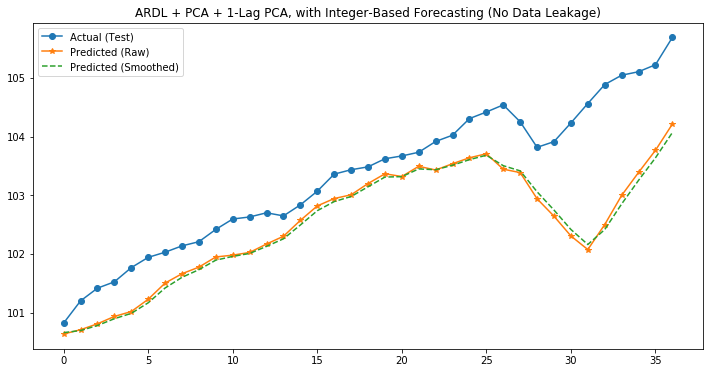

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.stattools import pacf

from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pykalman import KalmanFilter

# Loading data
file_path = "../Data/train/trains1990s.csv"
df = pd.read_csv(file_path)

# Convert to datetime and set index
df["observation_date"] = pd.to_datetime(df["observation_date"])
df.set_index("observation_date", inplace=True)

# Ensure target
if "fred_PCEPI" not in df.columns:
    raise ValueError("Column 'fred_PCEPI' not found in dataset")

# Drop rows that have missing values in ANY column
df.dropna(axis=0, how="any", inplace=True)

# Take log of the target
df["log_pcepi"] = np.log(df["fred_PCEPI"])

print(f"Remaining rows after dropna: {len(df)}")

# Train/Test split
train_size = int(0.90 * len(df))
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"\nTrain set size: {len(train_df)}")
print(f"Test  set size: {len(test_df)}")

# Remove near-constant columns
def drop_near_constant_cols(dataframe, threshold=1e-6):
    dropped_cols, keep_cols = [], []
    for col in dataframe.columns:
        if dataframe[col].std() <= threshold:
            dropped_cols.append(col)
        else:
            keep_cols.append(col)
    return dataframe[keep_cols], dropped_cols

all_exog_cols = [c for c in df.columns if c not in ["fred_PCEPI", "log_pcepi"]]
train_exog_full = train_df[all_exog_cols]
test_exog_full  = test_df[all_exog_cols]

train_exog_clean, dropped_cols = drop_near_constant_cols(train_exog_full, threshold=1e-6)
test_exog_clean = test_exog_full.drop(columns=dropped_cols, errors="ignore")

print(f"\nDropped near-constant exogenous columns: {dropped_cols}")
print(f"Remaining exog columns after drop: {len(train_exog_clean.columns)}")

# PCA Transform
NUM_COMPONENTS = 10
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(train_exog_clean)  # fit on train only

train_exog_pca = pca.transform(train_exog_clean)
test_exog_pca  = pca.transform(test_exog_clean)

pca_cols = [f"PC{i+1}" for i in range(NUM_COMPONENTS)]
train_exog = pd.DataFrame(train_exog_pca, index=train_df.index, columns=pca_cols)
test_exog  = pd.DataFrame(test_exog_pca,  index=test_df.index,  columns=pca_cols)

# Creating 1 lag of the PCA Components
def add_lags_to_pca(df_pca, lags=1):
    out_df = df_pca.copy()
    for col in df_pca.columns:
        for lag_i in range(1, lags+1):
            out_df[f"{col}_L{lag_i}"] = df_pca[col].shift(lag_i)
    return out_df

train_exog_lags = add_lags_to_pca(train_exog, lags=1)
test_exog_lags  = add_lags_to_pca(test_exog,  lags=1)

# Drop the NaNs from shifting
train_exog_lags.dropna(inplace=True)
test_exog_lags.dropna(inplace=True)

# Align the target with the new exog indexes
train_target = train_df["log_pcepi"].loc[train_exog_lags.index]
test_target = test_df["fred_PCEPI"].loc[test_exog_lags.index]

print(f"\nAfter adding 1 lag, train exog shape: {train_exog_lags.shape}")
print(f"Train target shape: {train_target.shape}")
print(f"Test exog shape: {test_exog_lags.shape}")
print(f"Test target shape: {test_target.shape}")

# Best Lag selection for the target (no differencing)
def best_lag_selection(train_series, max_lags=12):
    pacf_vals = pacf(train_series, nlags=max_lags)
    best_pacf_lag = np.argmax(np.abs(pacf_vals[1:])) + 1

    best_aic_lag, best_aic = 1, float("inf")
    for lag in range(1, max_lags + 1):
        y = train_series[lag:]
        X = train_series.shift(lag)[lag:]
        X = sm.add_constant(X, prepend=True)
        try:
            model = sm.OLS(y, X).fit()
            if model.aic < best_aic:
                best_aic_lag = lag
                best_aic = model.aic
        except:
            continue
    return min(best_pacf_lag, best_aic_lag)

best_lag = best_lag_selection(train_target, max_lags=12)
print(f"\nSelected best AR lag for target: {best_lag}")

# Convert everything to integer indexing
# Because ARDL tries to produce date-based forecasts for the entire date range,
# we can convert both train and test to 0-based integer index so we produce
# exactly as many forecasts as test_exog_lags rows.

train_index = np.arange(len(train_exog_lags))
test_index  = np.arange(len(test_exog_lags))

train_exog_lags_int = train_exog_lags.copy()
test_exog_lags_int  = test_exog_lags.copy()

train_exog_lags_int.index = train_index
test_exog_lags_int.index  = test_index

train_target_int = pd.Series(train_target.values, index=train_index)
test_target_int  = pd.Series(test_target.values, index=test_index)

# ARDL model using integer index
final_model = ARDL(
    endog=train_target_int,
    exog=train_exog_lags_int,
    lags=best_lag,
    trend='ct'
).fit()

print("\n=== ARDL (levels) Model Summary ===")
print(final_model.summary())

# Forecast with Exog out-of-sample (Integer-based)
# Will produce exactly `len(test_exog_lags_int)` forecasts
start_i = len(train_exog_lags_int)
end_i   = start_i + len(test_exog_lags_int) - 1

pred_log_test = final_model.predict(
    start=start_i,
    end=end_i,
    exog_oos=test_exog_lags_int  # The same # of rows as the forecast steps
)

# pred_log_test is now indexed from `start_i` to `end_i`
# re-index it to 0..len(test_exog_lags_int)-1 for convenience:
pred_log_test.index = test_index

# Exponentiate back to original scale
predictions_raw = np.exp(pred_log_test)

# Kalman Filter
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)
predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), index=predictions_raw.index)

# Evaluation
y_true = test_target_int.reindex(test_index)  # same integer index

mae_raw  = mean_absolute_error(y_true, predictions_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, predictions_raw))

mae_smooth  = mean_absolute_error(y_true, predictions_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, predictions_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Predictions       => MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed Predictions  => MAE = {mae_smooth:.4f}, RMSE = {rmse_smooth:.4f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(predictions_raw.index, predictions_raw, label="Predicted (Raw)", marker="*")
plt.plot(predictions_smoothed.index, predictions_smoothed, label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title("ARDL + PCA + 1-Lag PCA, with Integer-Based Forecasting (No Data Leakage)")
plt.show()
